In [ ]:
# !pip install  datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# pip install --upgrade transformers peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.13.2
    Uninstalling peft-0.13.2:
      Successfully uninstalled peft-0.13.2


In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ["HF_HOME"] = "./.huggingface"
os.environ["HF_TOKEN"] = "./HF_token"

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# Load Dataset

In [ ]:
def load_reviews(file_path):
    df = pd.read_csv(file_path)
    return df

positive_df = load_reviews("English/positive_dataset_en.csv")
neutral_df = load_reviews("English/neutral_dataset_en.csv")
negative_df = load_reviews("English/negative_dataset_en.csv")

In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
neutral_df['label'] = 1   # Neutral
positive_df['label'] = 2  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Neutral', 'Positive'])
})

combined_df = pd.concat([negative_df, neutral_df, positive_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/123950 [00:00<?, ? examples/s]

In [ ]:
# Step 2: Split the dataset
splits = dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = splits['train']
test_dataset = splits['test']

In [ ]:
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 123950
})


# NLLB-LLM2Vec (classifier trained on ENGLISH data)

In [ ]:
# 加载模型和tokenizer
model_name = "fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="tgl_Latn") # change the source language accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/123950 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [ ]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model
from peft.tuners.lora.config import LoraConfig

# Adjust LoRA settings for sentiment analysis
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=r".*llm2vec.*(self_attn\.(q|k|v|o)_proj|mlp\.(gate|up|down)_proj).*",
    bias="none",
    task_type="SEQ_CLS"
)

# Load model and apply LoRA
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Sentiment analysis has three classes
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)
model = get_peft_model(model, lora_config)
model.to(device)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): NLLBLLM2VecForSequenceClassification(
      (model): NLLBLLM2Vec(
        (nllb_encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (activation_fn): ReLU()
              (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./sentiment_model",
    num_train_epochs=3,
    # weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    # warmup_steps=500,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=500,  # Save model every 500 steps
    learning_rate=5e-5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',  # Disable logging to all integrations
    logging_dir="./logs",
    logging_steps=500,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
torch.cuda.empty_cache()
trainer.train()

trainer.save_model("./en-sentiment_model")

In [ ]:
# Save the tokenizer
tokenizer.save_pretrained("./en-sentiment_model")

('./en-sentiment_model/tokenizer_config.json',
 './en-sentiment_model/special_tokens_map.json',
 './en-sentiment_model/sentencepiece.bpe.model',
 './en-sentiment_model/added_tokens.json',
 './en-sentiment_model/tokenizer.json')

In [ ]:
eval_results = trainer.evaluate()

print(eval_results)

Step,Training Loss,Validation Loss,Accuracy
500,0.163500,0.089433,0.981041
1000,0.096300,0.048961,0.989351
1500,0.081600,0.062719,0.987898
2000,0.075800,0.069783,0.987777
2500,0.061600,0.048804,0.990843
2574,0.061600,0.061742,0.990157


{'eval_loss': 0.06174164637923241, 'eval_accuracy': 0.9901573215006051}


In [ ]:
eval_results

{'eval_loss': 0.06174164637923241, 'eval_accuracy': 0.9901573215006051}

In [ ]:
trainer.save_model("./en-sentiment_model")

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./en-sentiment_model"

# Create a zip file of the model directory
shutil.make_archive("en-sentiment_model", "zip", model_dir)

# Download the zip file to local
files.download("en-sentiment_model.zip")

## Evaluation on Tagalog-English Dataset

In [ ]:
positive_df = load_reviews("Taglish/positive_dataset.csv")
neutral_df = load_reviews("Taglish/neutral_dataset.csv")
negative_df = load_reviews("Taglish/negative_dataset.csv")

In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
neutral_df['label'] = 1   # Neutral
positive_df['label'] = 2  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Neutral', 'Positive'])
})

combined_df = pd.concat([negative_df, neutral_df, positive_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
# Step 1: Perform prediction
prediction_output = trainer.predict(test_dataset)

# Step 2: Access predictions and true labels
preds = prediction_output.predictions
labels = prediction_output.label_ids

Step,Training Loss,Validation Loss,Accuracy
500,0.163500,0.089433,0.981041
1000,0.096300,0.048961,0.989351
1500,0.081600,0.062719,0.987898
2000,0.075800,0.069783,0.987777
2500,0.061600,0.048804,0.990843
2574,0.061600,0.061742,0.990157


In [ ]:
# Step 4: Extract the correct tensor from the tuple
preds = preds[0]  # Assuming the first element contains the logits or predictions

# Step 5: Convert logits to class predictions if necessary
if len(preds.shape) == 2:  # Assuming logits are 2-dimensional
    preds = np.argmax(preds, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", preds.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, preds, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (4423,)
Predictions shape: (4423,)
Accuracy: 0.7372823875197829
Precision: 0.6809138274514248
Recall: 0.7372823875197829
F1-score: 0.6873446965482505


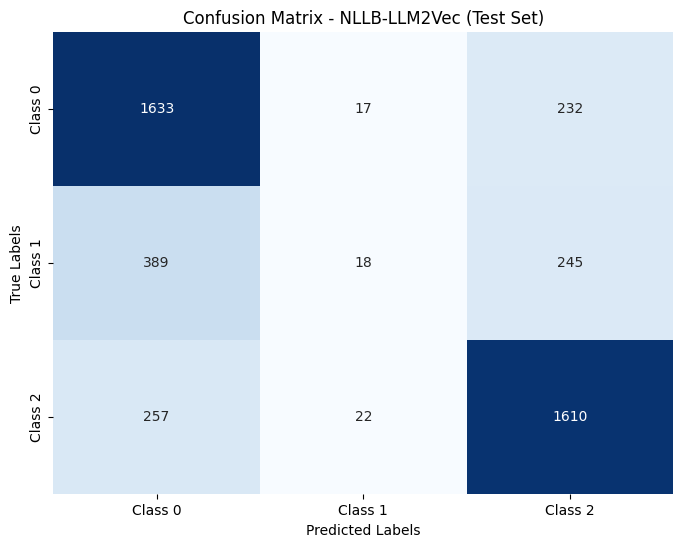

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - NLLB-LLM2Vec (Test Set)")
plt.show()

# NLLB-LLM2Vec (classifier fine-tuned on code-switched data)

In [ ]:
import zipfile

# Path to the zip file
zip_file_path = "./NLLB-LLM2VEC-Tagalog.zip"

# Directory to extract the contents
extract_to = "./ex"

# Create the extraction directory if it doesn't exist
import os
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: ./ex


In [ ]:
# Load the fine-tuned model and tokenizer
model_name = "./NLLB-LLM2VEC-Tagalog"  # Path to the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=3)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Function to tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Convert the dataset to a PyTorch DataLoader
from torch.utils.data import DataLoader

test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.7934

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.83      0.84      1882
     Neutral       0.91      0.80      0.85      1889
    Positive       0.46      0.65      0.54       652

    accuracy                           0.79      4423
   macro avg       0.74      0.76      0.75      4423
weighted avg       0.82      0.79      0.80      4423


Confusion Matrix:
[[1564   72  246]
 [ 113 1520  256]
 [ 147   80  425]]


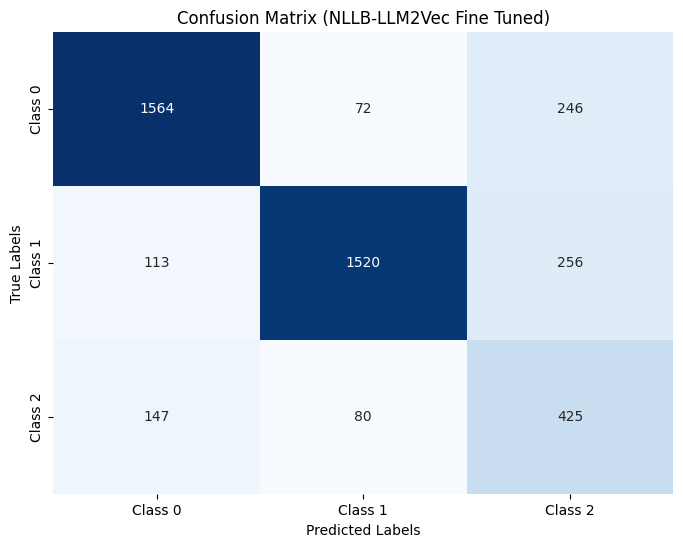

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (NLLB-LLM2Vec Fine Tuned)")
plt.show()

# BASELINE MODELS

# Evaluation using pre-trained models (no further fine-tuning)

## XLM-R-base-sentiment-analysis

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/22113 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
from torch.utils.data import DataLoader

# Convert the tokenized test dataset to PyTorch tensors
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.7264

Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.88      0.78      1882
     Neutral       0.26      0.15      0.20       652
    Positive       0.86      0.77      0.81      1889

    accuracy                           0.73      4423
   macro avg       0.61      0.60      0.60      4423
weighted avg       0.71      0.73      0.71      4423


Confusion Matrix:
[[1661  138   83]
 [ 400  101  151]
 [ 294  144 1451]]


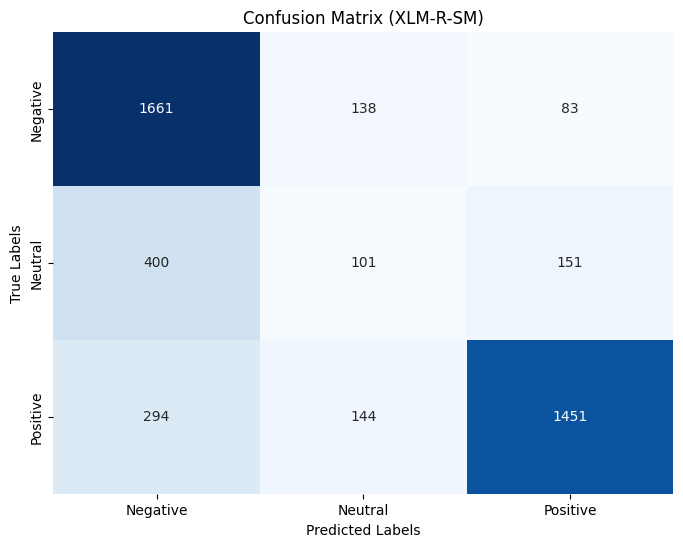

In [ ]:
# Plot the confusion matrix as a heatmap (TEST SET)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (XLM-R-SM)")
plt.show()

## Fine-tuned XLMR-SM (English)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
def load_reviews(file_path):
    df = pd.read_csv(file_path)
    return df

positive_df = load_reviews("English/positive_dataset_en.csv")
neutral_df = load_reviews("English/neutral_dataset_en.csv")
negative_df = load_reviews("English/negative_dataset_en.csv")

In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
neutral_df['label'] = 1   # Neutral
positive_df['label'] = 2  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Neutral', 'Positive'])
})

combined_df = pd.concat([negative_df, neutral_df, positive_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/123950 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/123950 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_XLMR-SM-English")
tokenizer.save_pretrained("./fine_tuned_XLMR-SM-English")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-50cfb5f4b657>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.032100,0.037370,0.991650


('./fine_tuned_XLMR-SM-English/tokenizer_config.json',
 './fine_tuned_XLMR-SM-English/special_tokens_map.json',
 './fine_tuned_XLMR-SM-English/sentencepiece.bpe.model',
 './fine_tuned_XLMR-SM-English/added_tokens.json',
 './fine_tuned_XLMR-SM-English/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_XLMR-SM-English"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_XLMR-SM-English", "zip", model_dir)

# Download the zip file to local
# files.download("fine_tuned_XLMR-SM-English.zip")

'/content/fine_tuned_XLMR-SM-English.zip'

### Evaluation on Tagalog-English Dataset

In [ ]:
# Load the fine-tuned model and tokenizer
model_name = "./fine_tuned_XLMR-SM-English"  # Path to the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
def load_reviews(file_path):
    df = pd.read_csv(file_path)
    return df

positive_df = load_reviews("Taglish/positive_dataset.csv")
neutral_df = load_reviews("Taglish/neutral_dataset.csv")
negative_df = load_reviews("Taglish/negative_dataset.csv")

In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
neutral_df['label'] = 1   # Neutral
positive_df['label'] = 2  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Neutral', 'Positive'])
})

combined_df = pd.concat([negative_df, neutral_df, positive_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
# Convert the dataset to a PyTorch DataLoader
from torch.utils.data import DataLoader

test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average='weighted'
)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7449694777300475
Precision: 0.7083708257914721
Recall: 0.7449694777300475
F1-score: 0.7178327125293016


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.73      0.89      0.80      1882
     Neutral       0.31      0.13      0.18       652
    Positive       0.82      0.82      0.82      1889

    accuracy                           0.74      4423
   macro avg       0.62      0.61      0.60      4423
weighted avg       0.71      0.74      0.72      4423



In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1670   73  139]
 [ 370   83  199]
 [ 237  110 1542]]


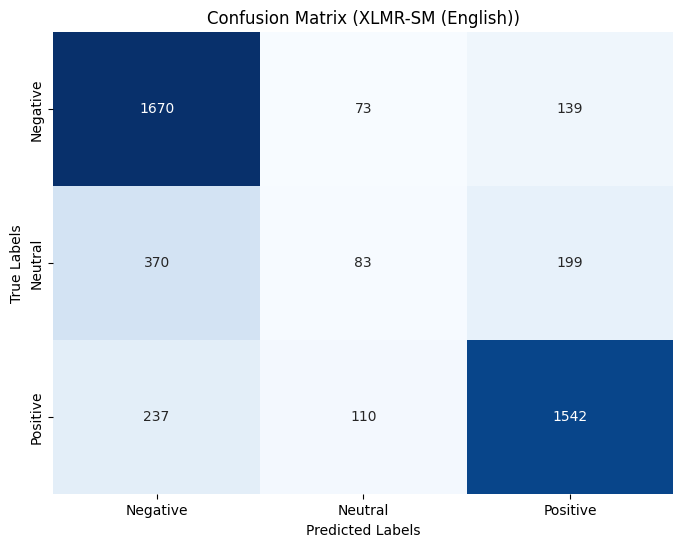

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (XLMR-SM (English))")
plt.show()

## Fine-tuned XLMR-SM (code-switched)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
def load_reviews(file_path):
    df = pd.read_csv(file_path)
    return df

positive_df = load_reviews("Taglish/positive_dataset.csv")
neutral_df = load_reviews("Taglish/neutral_dataset.csv")
negative_df = load_reviews("Taglish/negative_dataset.csv")

In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
neutral_df['label'] = 1   # Neutral
positive_df['label'] = 2  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Neutral', 'Positive'])
})

combined_df = pd.concat([negative_df, neutral_df, positive_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_XLMR-SM")
tokenizer.save_pretrained("./fine_tuned_XLMR-SM")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-7f0f08a512e3>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.582600,0.533940,0.784761
2,0.493600,0.531942,0.785440
3,0.421000,0.585201,0.783631


('./fine_tuned_XLMR-SM/tokenizer_config.json',
 './fine_tuned_XLMR-SM/special_tokens_map.json',
 './fine_tuned_XLMR-SM/sentencepiece.bpe.model',
 './fine_tuned_XLMR-SM/added_tokens.json',
 './fine_tuned_XLMR-SM/tokenizer.json')

In [ ]:
# Load the fine-tuned model and tokenizer
model_name = "./fine_tuned_XLMR-SM"  # Path to the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the test dataset
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert the dataset to a PyTorch DataLoader
from torch.utils.data import DataLoader

test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Map:   0%|          | 0/4423 [00:00<?, ? examples/s]

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.7852

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.88      0.84      1882
     Neutral       0.41      0.36      0.38       652
    Positive       0.87      0.84      0.86      1889

    accuracy                           0.79      4423
   macro avg       0.70      0.69      0.69      4423
weighted avg       0.78      0.79      0.78      4423


Confusion Matrix:
[[1654  152   76]
 [ 268  233  151]
 [ 119  184 1586]]


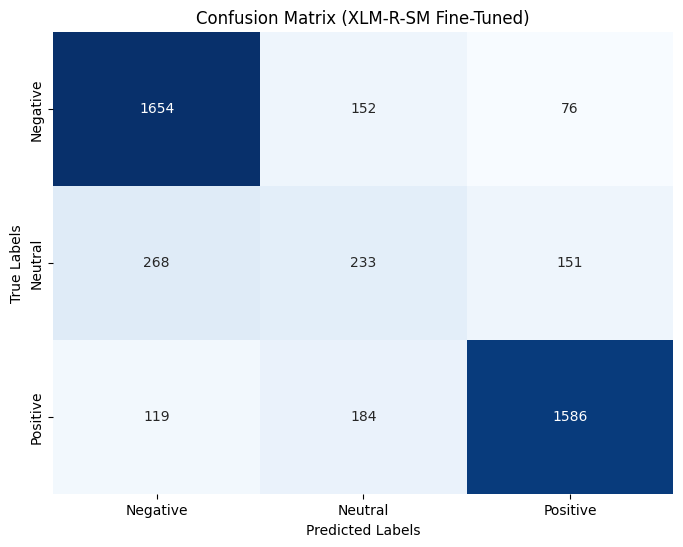

In [ ]:
# Plot the confusion matrix as a heatmap (TEST SET)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (XLM-R-SM Fine-Tuned)")
plt.show()

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_XLMR-SM"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_XLMR-SM", "zip", model_dir)

# Download the zip file to local
files.download("fine_tuned_XLMR-SM.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# RoBERTa-tl-sentiment-analysis

For this model, 0 - negative, 1 - positive, 2 - neutral

In [ ]:
def load_reviews(file_path):
    df = pd.read_csv(file_path)
    return df

positive_df = load_reviews("Taglish/positive_dataset.csv")
neutral_df = load_reviews("Taglish/neutral_dataset.csv")
negative_df = load_reviews("Taglish/negative_dataset.csv")

In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
positive_df['label'] = 1  # Positive
neutral_df['label'] = 2   # Neutral

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Positive', 'Neutral'])
})

combined_df = pd.concat([negative_df, positive_df, neutral_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
# # Step 2: Split the dataset
# splits = dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
# train_dataset = splits['train']
# test_dataset = splits['test']

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dost-asti/RoBERTa-tl-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader

# Convert the tokenized test dataset to PyTorch tensors
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(tokenized_dataset, batch_size=16)

In [ ]:
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Positive", "Neutral"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Reorder the classification report
report_lines = classification_rep.split("\n")

# Reorder the lines: Class 0, Class 2, Class 1
class_0_line = None
class_1_line = None
class_2_line = None
for line in report_lines:
    if "Negative" in line:
        class_0_line = line
    elif "Positive" in line:
        class_1_line = line
    elif "Neutral" in line:
        class_2_line = line

# Reconstruct the report with the desired order
reordered_report = "\n".join([
    report_lines[0],  # Header line
    class_0_line,    # Class 0
    class_2_line,    # Class 2
    class_1_line,    # Class 1
    report_lines[-2],  # Macro avg
    report_lines[-1]   # Weighted avg
])

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Reorder the confusion matrix
order = [0, 2, 1]
reordered_conf_matrix = conf_matrix[order, :][:, order]

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(reordered_report)
print("\nConfusion Matrix:")
print(reordered_conf_matrix)

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(reordered_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (RoBERTa-tl-SM)")
plt.show()

# ROBERTA-tl-sentiment-analysis (no fine-tuning)

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Positive", "Neutral"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Reorder the classification report
report_lines = classification_rep.split("\n")

# Reorder the lines: Class 0, Class 2, Class 1
class_0_line = None
class_1_line = None
class_2_line = None
for line in report_lines:
    if "Negative" in line:
        class_0_line = line
    elif "Positive" in line:
        class_1_line = line
    elif "Neutral" in line:
        class_2_line = line

# Reconstruct the report with the desired order
reordered_report = "\n".join([
    report_lines[0],  # Header line
    class_0_line,    # Class 0
    class_2_line,    # Class 2
    class_1_line,    # Class 1
    report_lines[-2],  # Macro avg
    report_lines[-1]   # Weighted avg
])

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Reorder the confusion matrix
order = [0, 2, 1]
reordered_conf_matrix = conf_matrix[order, :][:, order]

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(reordered_report)
print("\nConfusion Matrix:")
print(reordered_conf_matrix)

Accuracy: 0.6582

Classification Report:
              precision    recall  f1-score   support
    Negative       0.72      0.67      0.69      1882
     Neutral       0.25      0.07      0.11       652
    Positive       0.64      0.85      0.73      1889
weighted avg       0.62      0.66      0.62      4423


Confusion Matrix:
[[1259   85  538]
 [ 258   47  347]
 [ 231   53 1605]]


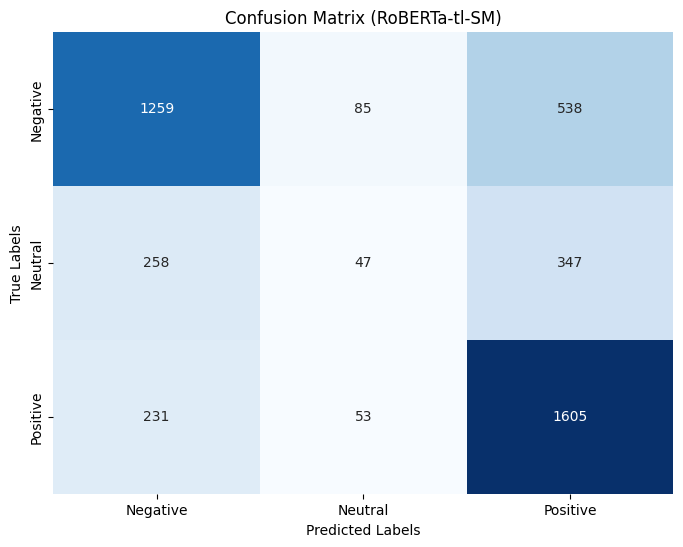

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(reordered_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (RoBERTa-tl-SM)")
plt.show()

## Fine-tuned RoBERTa (English)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dost-asti/RoBERTa-tl-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/469k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/269k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
def load_reviews(file_path):
    df = pd.read_csv(file_path)
    return df

positive_df = load_reviews("English/positive_dataset_en.csv")
neutral_df = load_reviews("English/neutral_dataset_en.csv")
negative_df = load_reviews("English/negative_dataset_en.csv")

In [ ]:
# Step 1: Combine the datasets (Following labels for RoBERTa-tl)
negative_df['label'] = 0  # Negative
neutral_df['label'] = 2   # Neutral
positive_df['label'] = 1  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Positive','Neutral'])
})

combined_df = pd.concat([negative_df, positive_df, neutral_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/123950 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/123950 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_ROBERTA-tl-English")
tokenizer.save_pretrained("./fine_tuned_ROBERTA-tl-English")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-43-95ba4ff43479>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.088300,0.092480,0.976765


('./fine_tuned_ROBERTA-tl-English/tokenizer_config.json',
 './fine_tuned_ROBERTA-tl-English/special_tokens_map.json',
 './fine_tuned_ROBERTA-tl-English/vocab.json',
 './fine_tuned_ROBERTA-tl-English/merges.txt',
 './fine_tuned_ROBERTA-tl-English/added_tokens.json',
 './fine_tuned_ROBERTA-tl-English/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_ROBERTA-tl-English"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_ROBERTA-tl-English", "zip", model_dir)

# Download the zip file to local
# files.download("fine_tuned_XLMR-SM-English.zip")

'/content/fine_tuned_ROBERTA-tl-English.zip'

### Evaluation on Tagalog-English Dataset

In [ ]:
positive_df = load_reviews("Taglish/positive_dataset.csv")
neutral_df = load_reviews("Taglish/neutral_dataset.csv")
negative_df = load_reviews("Taglish/negative_dataset.csv")

In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
neutral_df['label'] = 2   # Neutral
positive_df['label'] = 1  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Positive', 'Neutral'])
})

combined_df = pd.concat([negative_df, neutral_df, positive_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/22113 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
# Step 1: Perform prediction
prediction_output = trainer.predict(tokenized_dataset)

# Step 2: Access predictions and true labels
preds = prediction_output.predictions
labels = prediction_output.label_ids

In [ ]:
preds[:10]

array([[ 5.3554688 , -2.2578125 , -3.109375  ],
       [ 6.6289062 , -2.9355469 , -3.2675781 ],
       [ 6.0742188 , -2.5644531 , -3.2480469 ],
       [ 6.3867188 , -2.9960938 , -3.0058594 ],
       [ 6.4609375 , -2.8554688 , -3.2109375 ],
       [ 6.59375   , -2.7460938 , -3.3925781 ],
       [ 6.1523438 , -2.2070312 , -3.7363281 ],
       [ 2.0898438 , -1.7998047 , -1.09375   ],
       [ 6.25      , -2.8945312 , -2.9785156 ],
       [-0.36010742,  1.2558594 , -2.109375  ]], dtype=float32)

In [ ]:
# Step 4: Extract the correct tensor from the tuple
# preds = preds[0]  # Assuming the first element contains the logits or predictions

# Step 5: Convert logits to class predictions if necessary
if len(preds.shape) == 2:  # Assuming logits are 2-dimensional
    preds = np.argmax(preds, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", preds.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, preds, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (22113,)
Predictions shape: (22113,)
Accuracy: 0.7125220458553791
Precision: 0.6678156217219168
Recall: 0.7125220458553791
F1-score: 0.6735025107396938


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, preds, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.67      0.89      0.77      9408
     Neutral       0.80      0.77      0.78      9443
    Positive       0.27      0.06      0.09      3262

    accuracy                           0.71     22113
   macro avg       0.58      0.57      0.55     22113
weighted avg       0.67      0.71      0.67     22113



In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[8337  844  227]
 [1942 7232  269]
 [2078  997  187]]


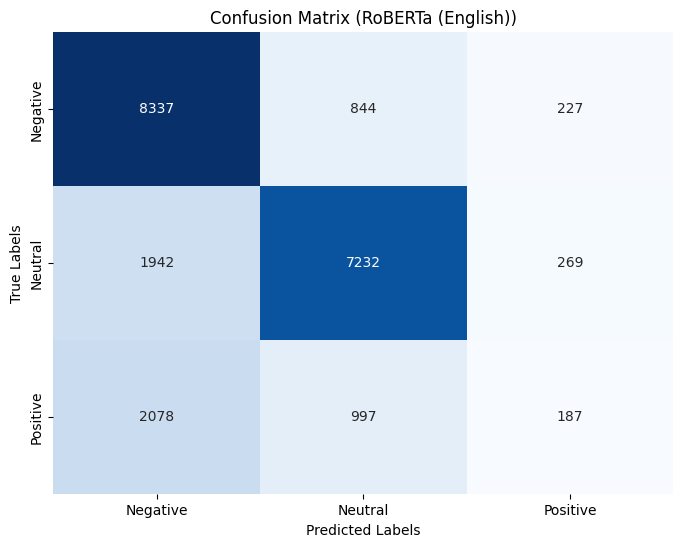

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (RoBERTa (English))")
plt.show()

## Fine-tuned ROBERTA-tl-sentiment-analysis|

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_ROBERTA-tl")
tokenizer.save_pretrained("./fine_tuned_ROBERTA-tl")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-e32cb117a50b>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.619600,0.620251,0.749491
2,0.478600,0.593727,0.777527
3,0.341600,0.691897,0.765544


('./fine_tuned_ROBERTA/tokenizer_config.json',
 './fine_tuned_ROBERTA/special_tokens_map.json',
 './fine_tuned_ROBERTA/vocab.json',
 './fine_tuned_ROBERTA/merges.txt',
 './fine_tuned_ROBERTA/added_tokens.json',
 './fine_tuned_ROBERTA/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_ROBERTA-tl"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_ROBERTA-tl", "zip", model_dir)

# Download the zip file to local
files.download("fine_tuned_ROBERTA-tl.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the fine-tuned model and tokenizer
model_name = "./fine_tuned_ROBERTA-tl"  # Path to the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the test dataset
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert the dataset to a PyTorch DataLoader
from torch.utils.data import DataLoader

test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Map:   0%|          | 0/4423 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader

# Convert the tokenized test dataset to PyTorch tensors
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Positive", "Neutral"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Reorder the classification report
report_lines = classification_rep.split("\n")

# Reorder the lines: Class 0, Class 2, Class 1
class_0_line = None
class_1_line = None
class_2_line = None
for line in report_lines:
    if "Negative" in line:
        class_0_line = line
    elif "Positive" in line:
        class_1_line = line
    elif "Neutral" in line:
        class_2_line = line

# Reconstruct the report with the desired order
reordered_report = "\n".join([
    report_lines[0],  # Header line
    class_0_line,    # Class 0
    class_2_line,    # Class 2
    class_1_line,    # Class 1
    report_lines[-2],  # Macro avg
    report_lines[-1]   # Weighted avg
])

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Reorder the confusion matrix
order = [0, 2, 1]
reordered_conf_matrix = conf_matrix[order, :][:, order]

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(reordered_report)
print("\nConfusion Matrix:")
print(reordered_conf_matrix)

Accuracy: 0.7775

Classification Report:
              precision    recall  f1-score   support
    Negative       0.78      0.89      0.83      1882
     Neutral       0.43      0.20      0.28       652
    Positive       0.83      0.86      0.85      1889
weighted avg       0.75      0.78      0.76      4423


Confusion Matrix:
[[1683   83  116]
 [ 313  133  206]
 [ 171   95 1623]]


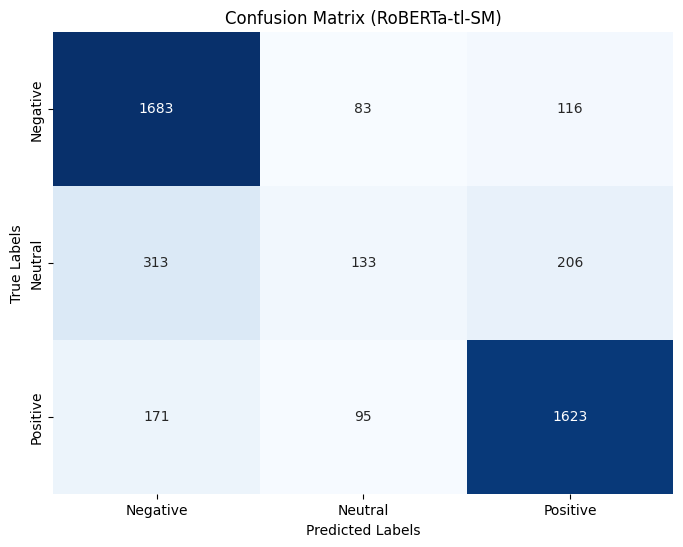

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(reordered_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (RoBERTa-tl-SM)")
plt.show()